In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

manjilkarki_deepfake_and_real_images_path = kagglehub.dataset_download('manjilkarki/deepfake-and-real-images')
azizzz07_inceptionnettt_model_path = kagglehub.dataset_download('azizzz07/inceptionnettt-model')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/inceptionnettt-model/best_model_inceptionv3.pth


In [ ]:
!pip install torch torchvision tqdm scikit-learn seaborn matplotlib


In [ ]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.calibration import calibration_curve
from collections import OrderedDict


In [ ]:
import torch
import torchvision.models as models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model with the correct aux_logits setting
model = models.inception_v3(pretrained=False, aux_logits=True)  # Change to True
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1)  # Adjust for binary classification
model = model.to(device)

# Load the saved model
path_to_model = "/kaggle/input/inceptionnettt-model/best_model_inceptionv3.pth"

# Load full model (not just state_dict)
loaded_model = torch.load(path_to_model, map_location=device)

# Handle DataParallel issue
if isinstance(loaded_model, torch.nn.DataParallel):
    loaded_model = loaded_model.module  # Extract model

# Load weights correctly
model.load_state_dict(loaded_model.state_dict())

# Set to evaluation mode
model.eval()
print("Model loaded successfully!")


Model loaded successfully!


<ipython-input-12-02d1149af090>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(path_to_model, map_location=device)


In [ ]:
# Define dataset path (Update this if needed)
dataset_path = "/kaggle/input/deepfake-and-real-images/Dataset"

# Define transforms
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load test dataset
test_dataset = datasets.ImageFolder(os.path.join(dataset_path, "Test"), transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [ ]:
# ======================
# Define Loss Function and Evaluate Model
# ======================

# Define loss function
criterion = torch.nn.BCEWithLogitsLoss()

# Initialize variables
total_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating Model"):
        inputs, labels = inputs.cuda(), labels.float().cuda().unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)

        # Get predicted probabilities
        preds = torch.sigmoid(outputs)
        all_preds.extend(preds.cpu().numpy().flatten().tolist())
        all_labels.extend(labels.cpu().numpy().flatten().tolist())

# Compute test loss and AUC
test_loss = total_loss / len(test_dataset)
test_auc = roc_auc_score(all_labels, all_preds) if len(set(all_labels)) > 1 else 0.0

# Print test loss and AUC
print(f"\nTest Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}")


Evaluating Model: 100%|██████████| 341/341 [00:35<00:00,  9.66it/s]


Test Loss: 0.4273, Test AUC: 0.8840


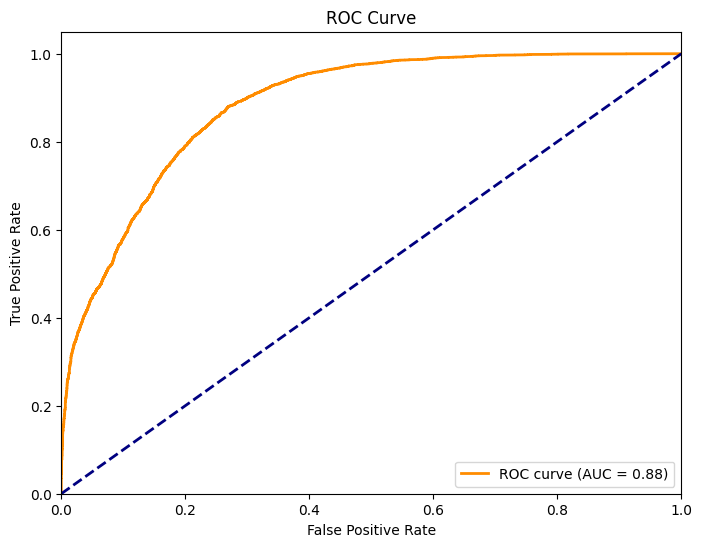

In [ ]:
# ======================
# ROC Curve
# ======================

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc_value = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


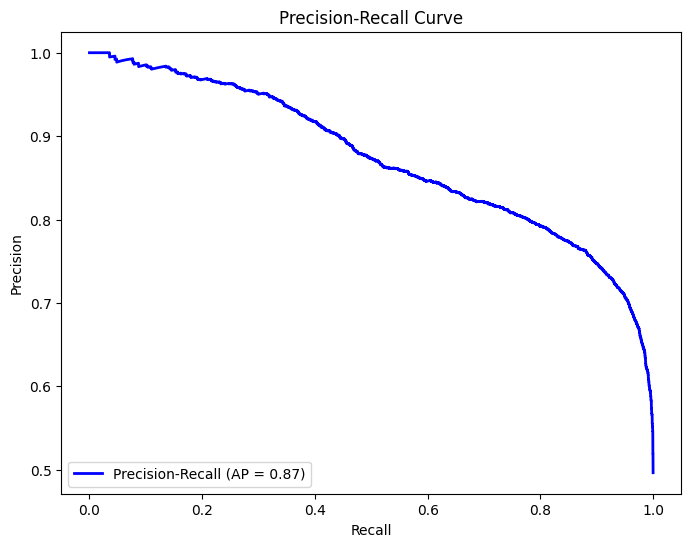

In [ ]:
# ======================
# Precision-Recall Curve
# ======================

# Calculate precision, recall, and thresholds
precision, recall, _ = precision_recall_curve(all_labels, all_preds)

# Calculate average precision score
average_precision = average_precision_score(all_labels, all_preds)

# Plot Precision-Recall curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


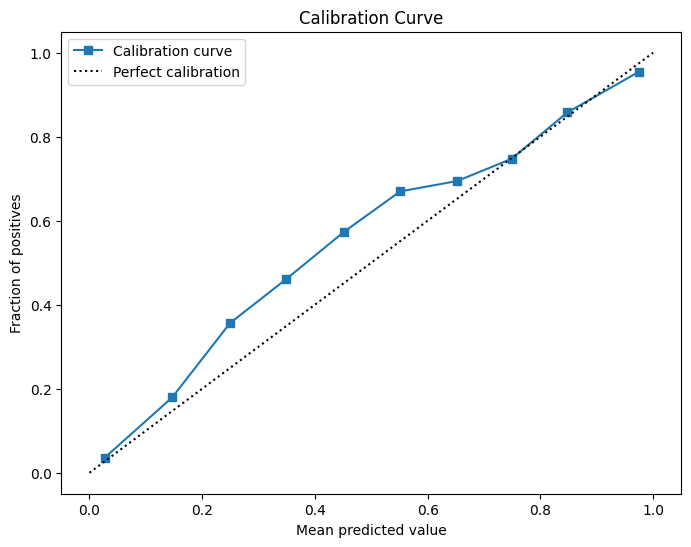

In [ ]:
# ======================
# Calibration Curve (Reliability Diagram)
# ======================

# Calculate the fraction of positives and mean predicted value
fraction_of_positives, mean_predicted_value = calibration_curve(all_labels, all_preds, n_bins=10, strategy='uniform')

# Plot Calibration curve
plt.figure(figsize=(8,6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Calibration curve')
plt.plot([0, 1], [0, 1], "k:", label="Perfect calibration")
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend(loc='upper left')
plt.show()


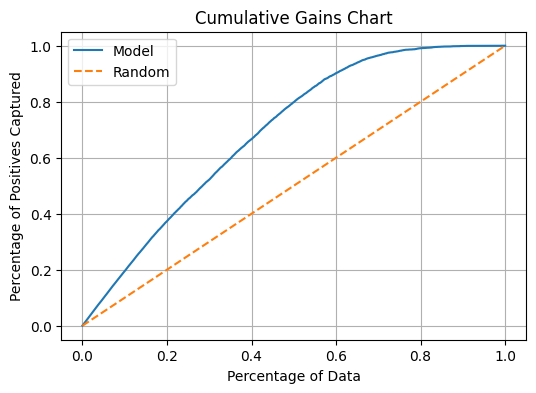

In [ ]:
# ======================
# Cumulative Gains Chart
# ======================

# Create a DataFrame with labels and predictions
df = pd.DataFrame({"label": all_labels, "pred": all_preds})

# Sort by predicted probabilities
df = df.sort_values("pred", ascending=False).reset_index(drop=True)

# Calculate cumulative positives and percentages
df["cumulative_positive"] = df["label"].cumsum()
df["percentage_positive"] = df["cumulative_positive"] / df["label"].sum()
df["percentage_data"] = (df.index + 1) / len(df)

# Plot Cumulative Gains Chart
plt.figure(figsize=(6, 4))
plt.plot(df["percentage_data"], df["percentage_positive"], label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("Percentage of Data")
plt.ylabel("Percentage of Positives Captured")
plt.title("Cumulative Gains Chart")
plt.legend()
plt.grid(True)
plt.show()


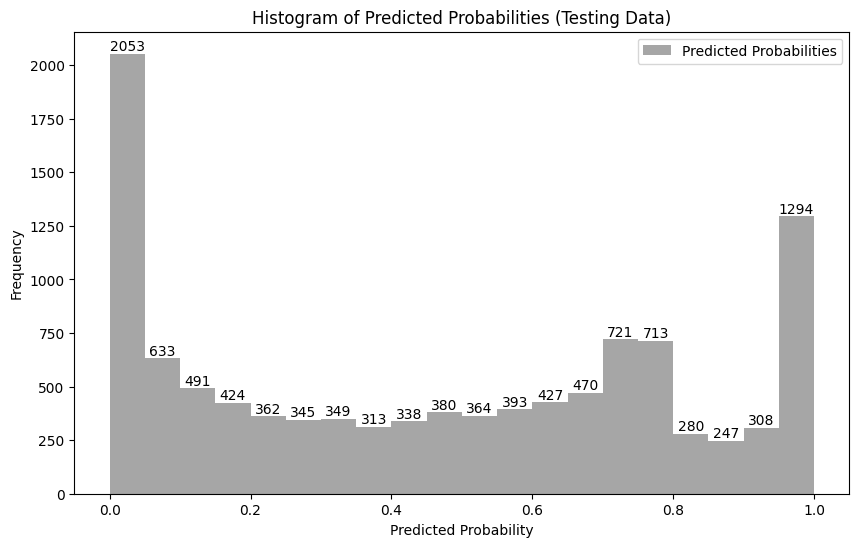

In [ ]:
# ======================
# Histogram of Predicted Probabilities
# ======================

# Plot histogram of predicted probabilities
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(all_preds, bins=20, color='gray', alpha=0.7, label='Predicted Probabilities')

# Add frequency count on each bar
for i in range(len(patches)):
    height = patches[i].get_height()
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, height + 0.5, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities (Testing Data)')
plt.legend(loc='upper right')
plt.show()



Threshold: 0.3
Test Accuracy: 0.7975


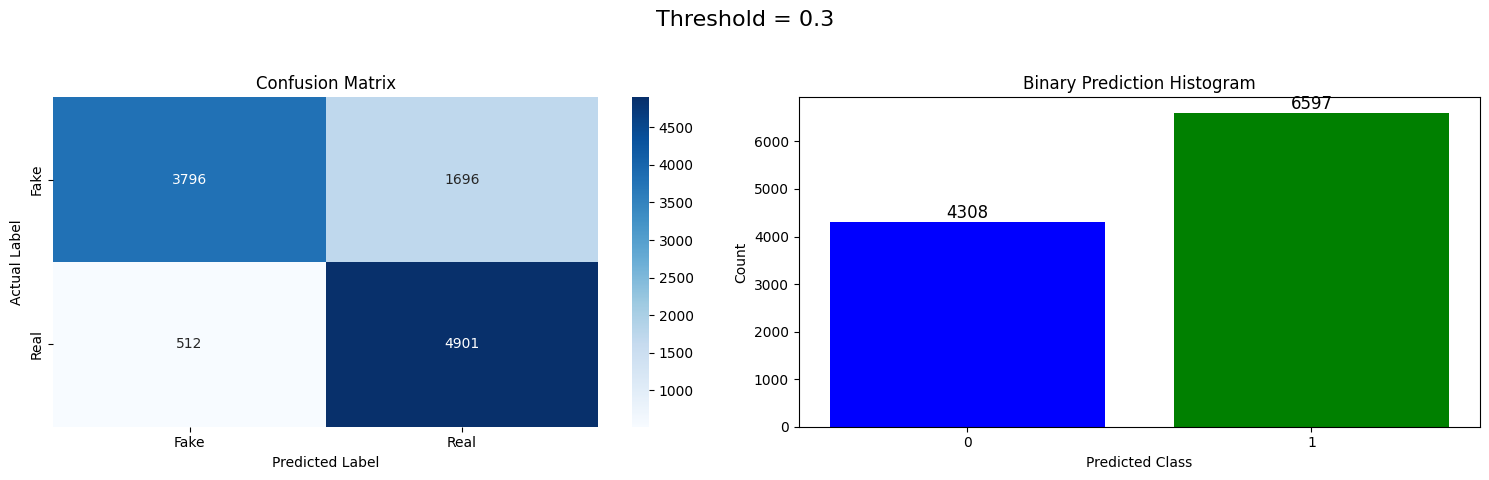


Threshold: 0.4
Test Accuracy: 0.8023


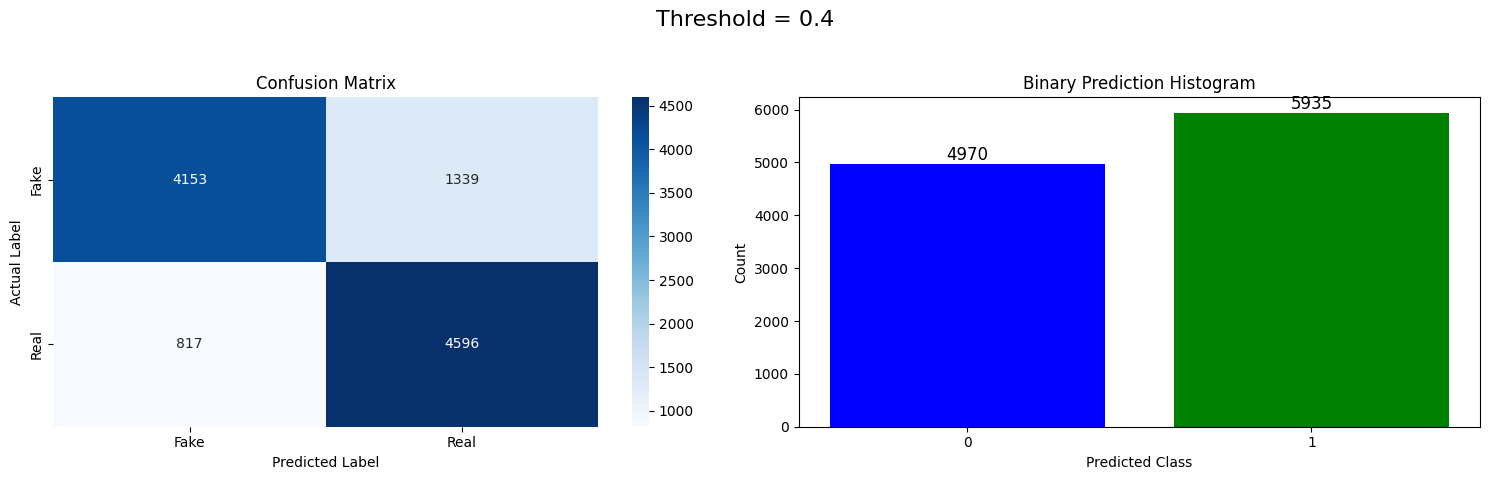


Threshold: 0.5
Test Accuracy: 0.7926


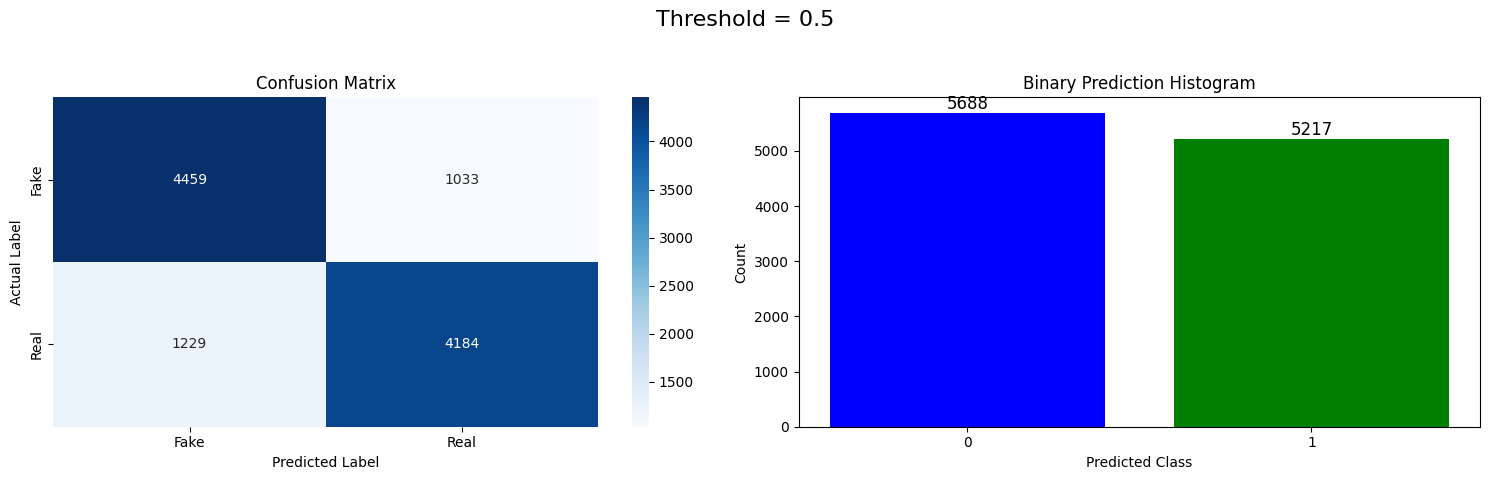


Threshold: 0.6
Test Accuracy: 0.7690


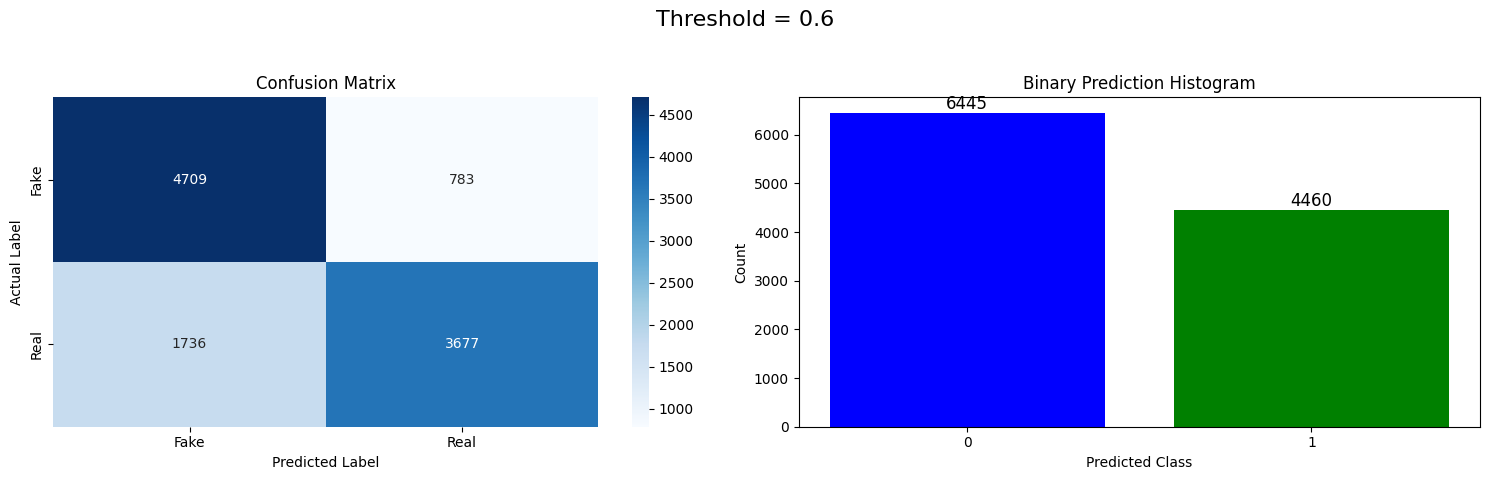


Threshold: 0.7
Test Accuracy: 0.7370


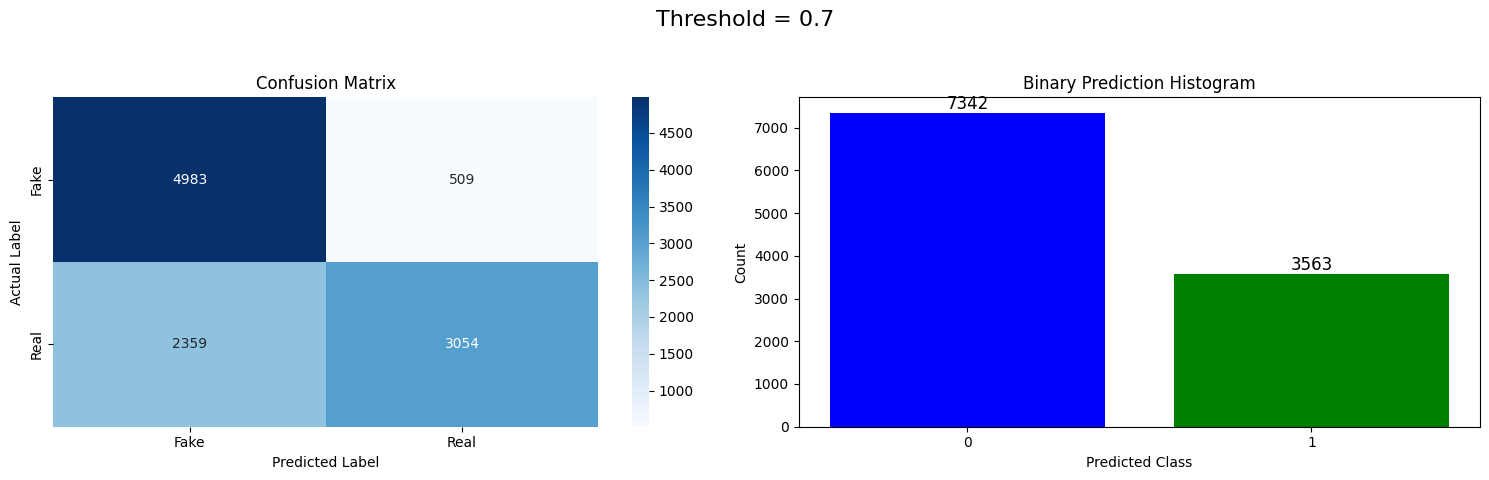

In [ ]:
# ======================
# Confusion Matrices and Accuracy for Different Thresholds
# ======================

# Define thresholds to evaluate
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

for thresh in thresholds:
    # Convert probabilities to binary predictions
    test_preds_labels = (np.array(all_preds) >= thresh).astype(int)
    test_labels_np = np.array(all_labels).astype(int)

    # Calculate accuracy for the current threshold
    test_accuracy = (test_preds_labels == test_labels_np).mean()

    # Print threshold and accuracy
    print(f"\nThreshold: {thresh}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Create a figure with 2 rows and 2 columns for organized plots (confusion matrix and binary prediction bar chart)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"Threshold = {thresh}", fontsize=16)

    # Subplot 1: Confusion Matrix Heatmap
    cm = confusion_matrix(test_labels_np, test_preds_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes,
                ax=axs[0])
    axs[0].set_xlabel('Predicted Label')
    axs[0].set_ylabel('Actual Label')
    axs[0].set_title('Confusion Matrix')

    # Subplot 2: Bar Chart of Binary Predictions with Count Annotation
    unique, counts = np.unique(test_preds_labels, return_counts=True)
    axs[1].bar(unique, counts, color=['blue', 'green'])
    axs[1].set_xticks([0, 1])
    axs[1].set_xlabel('Predicted Class')
    axs[1].set_ylabel('Count')
    axs[1].set_title('Binary Prediction Histogram')

    # Annotate each bar with its count
    for i, count in zip(unique, counts):
        axs[1].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
